# AIMLCZG567_Assignment_1_Group_18


                          
| Name            | BITS_ID     | Contribution |
|-----------------|-------------|--------------|
| Rahul           | 2024ad05284 | 100%         |
| Ankita Yadav    |             | 100%         |
|Rasampreet Singh |             | 100%         |
|Srinidhi S       |             | 100%         |



In [194]:
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import time

# ML Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack
import joblib
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

## LOAD CISA KEV DATA

In [195]:
def load_cisa_kev():
    print("Loading CISA KEV data...")
    url = "https://www.cisa.gov/sites/default/files/feeds/known_exploited_vulnerabilities.json"
    data = requests.get(url).json()
    kev_df = pd.DataFrame(data)
    kev_ids = set([item['cveID'] for item in data['vulnerabilities']])
    print(f"Loaded {len(kev_ids)} exploited CVEs from CISA. Sample....")
    print(kev_df.head())
    
    return kev_ids, kev_df

## Fetch CVEs from NVD

In [196]:
def fetch_cves(start_date="2025-01-01", end_date="2025-04-30", results_per_page=2000, apikey= None)-> pd.DataFrame:
    """
    Fetch CVEs from NVD API within a given date range.
    
    Args:
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.
        Note : The maximum allowable range when using any date range parameters is 120 consecutive days.
        results_per_page (int): Number of results per page (max 2000).
        
    
    Returns:
        list: A Data frame of CVE items.
    """
    print("\n Fetching CVEs for given date range...")
    base_url = f"https://services.nvd.nist.gov/rest/json/cves/2.0/?pubStartDate={start_date}T00:00:00.000&pubEndDate={end_date}T00:00:00.000"
    headers = {"apiKey" : apikey}

    all_cves = []
    start_index = 0

    while True:
        url = f"{base_url}&startIndex={start_index}&resultsPerPage={results_per_page}"
        response = requests.get(url, headers = headers )
        
        if response.status_code != 200:
            raise Exception(f"Error fetching data: {response.status_code} - {response.text}")
        
        data = response.json()
        cves = data.get("vulnerabilities", [])
        all_cves.extend(cves)
        
        # Check if there are more pages
        total_results = data.get("totalResults", 0)
        start_index += results_per_page
        
        if start_index >= total_results:
            break

    print(f"Loaded {len(all_cves)} CVEs from NVD. Sample....")
    fetched_cve_df = pd.DataFrame(all_cves)
    print(fetched_cve_df.head())
    return fetched_cve_df

## Flatten CVEs data

In [197]:
def flatten_cve(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Flatten the NVD 'vulnerabilities' structure from the DataFrame returned by fetch_cves.

    Parameters
    ----------
    df_raw : pd.DataFrame
        DataFrame returned by fetch_cves. Expected to have a column 'cve' with dicts.

    Returns
    -------
    pd.DataFrame
        Flattened DataFrame with selected NVD CVE fields.
    """
    if "cve" not in df_raw.columns:
        raise ValueError("Input df_raw must have a 'cve' column containing NVD CVE dicts.")

    # Normalize the nested 'cve' objects
    df_cve = pd.json_normalize(df_raw["cve"], sep=".")

    # --- Ensure expected columns exist ---
    for col, default in [
        ("descriptions", []),
        ("metrics", {}),
        ("weaknesses", []),
        ("configurations", []),
        ("references", []),
    ]:
        if col not in df_cve.columns:
            df_cve[col] = [default] * len(df_cve)

    # --- Utilities ---
    def _pick_english_description(descriptions):
        if isinstance(descriptions, list):
            for d in descriptions:
                if d.get("lang", "").lower() == "en":
                    return d.get("value")
            return descriptions[0].get("value") if descriptions else None
        return None

    def _extract_cvss(metrics):
        """
        Prefer v3.1, then v3.0, then v2. Returns dict with basic fields only.
        """
        out = {
            "cvss_version": None,
            "cvss_score": None,
            "cvss_severity": None,
            "cvss_vector": None,
            "exploitability_score": None,
            "impact_score": None,
        }
        if not isinstance(metrics, dict):
            return out

        def pick(metric_list, version_label):
            if isinstance(metric_list, list) and metric_list:
                m = metric_list[0]
                data = m.get("cvssData", {})
                return {
                    "cvss_version": version_label,
                    "cvss_score": data.get("baseScore"),
                    "cvss_severity": data.get("baseSeverity"),
                    "cvss_vector": data.get("vectorString"),
                    "exploitability_score": m.get("exploitabilityScore"),
                    "impact_score": m.get("impactScore"),
                }
            return None

        for key, label in [("cvssMetricV31", "3.1"), ("cvssMetricV30", "3.0"), ("cvssMetricV2", "2.0")]:
            candidate = pick(metrics.get(key), label)
            if candidate:
                return candidate
        return out

    def _extract_cwes(weaknesses):
        """
        Collect CWE identifiers (e.g., 'CWE-79') from weaknesses[].description[].value
        """
        cwes = []
        if isinstance(weaknesses, list):
            for w in weaknesses:
                for d in w.get("description", []):
                    val = d.get("value")
                    if val and "CWE-" in val:
                        cwes.append(val)
        cwes = sorted(set(cwes))
        return ";".join(cwes) if cwes else None

    def _parse_cpe23_uri(cpe_uri):
        # cpe:2.3:<part>:<vendor>:<product>:<version>:<update>:<edition>:<language>:...
        try:
            parts = cpe_uri.split(":")
            return {
                "cpe_part": parts[2] if len(parts) > 2 else None,     # 'a','o','h'
                "cpe_vendor": parts[3] if len(parts) > 3 else None,
                "cpe_product": parts[4] if len(parts) > 4 else None,
                "cpe_version": parts[5] if len(parts) > 5 else None,
            }
        except Exception:
            return {"cpe_part": None, "cpe_vendor": None, "cpe_product": None, "cpe_version": None}

    def _extract_affected_software(configurations):
        """
        Aggregate vendors/products/versions/part categories from configurations[].cpeMatch[].
        """
        vendors, products, versions, parts = set(), set(), set(), set()
        if not isinstance(configurations, list):
            return {
                "affected_vendors": None,
                "affected_products": None,
                "affected_versions": None,
                "affected_part_categories": None,
            }
        for node in configurations:
            for match in node.get("cpeMatch", []):
                cpe = match.get("criteria") or match.get("cpe23Uri")
                if not cpe:
                    continue
                parsed = _parse_cpe23_uri(cpe)
                v, p, ver, part = parsed["cpe_vendor"], parsed["cpe_product"], parsed["cpe_version"], parsed["cpe_part"]
                if v: vendors.add(v)
                if p: products.add(p)
                if ver and ver not in {"*", "-"}:  # filter placeholders
                    versions.add(ver)
                if part:
                    parts.add({"a": "application", "o": "operating_system", "h": "hardware"}.get(part, part))
        return {
            "affected_vendors": ";".join(sorted(vendors)) if vendors else None,
            "affected_products": ";".join(sorted(products)) if products else None,
            "affected_versions": ";".join(sorted(versions)) if versions else None,
            "affected_part_categories": ";".join(sorted(parts)) if parts else None,
        }

    def _extract_reference_features(refs):
        """
        Basic counts of references and tags (no binarization or leakage handling here).
        """
        n_refs = 0
        n_exploit = 0
        n_patch = 0
        n_vendor_adv = 0
        has_exploit_tag = 0
        if isinstance(refs, list):
            for r in refs:
                n_refs += 1
                tags = [t.lower() for t in (r.get("tags") or [])]
                if "exploit" in tags:
                    n_exploit += 1
                    has_exploit_tag = 1
                if "patch" in tags:
                    n_patch += 1
                if "vendor advisory" in tags:
                    n_vendor_adv += 1
        return {
            "references_count": n_refs,
            "references_exploit_count": n_exploit,
            "references_patch_count": n_patch,
            "references_vendor_advisory_count": n_vendor_adv,
            "has_exploit_tag": has_exploit_tag,
        }

    # --- Core fields ---
    df_cve["cve_id"] = df_cve.get("id")
    df_cve["published"] = pd.to_datetime(df_cve.get("published"), errors="coerce")
    df_cve["last_modified"] = pd.to_datetime(df_cve.get("lastModified"), errors="coerce")
    df_cve["vuln_status"] = df_cve.get("vulnStatus")

    # Descriptions
    df_cve["description"] = df_cve["descriptions"].apply(_pick_english_description)

    # CVSS
    cvss_series = df_cve["metrics"].apply(_extract_cvss)
    cvss_df = pd.DataFrame(cvss_series.tolist())
    df_cve = pd.concat([df_cve, cvss_df], axis=1)

    # CWE(s)
    df_cve["cwes"] = df_cve["weaknesses"].apply(_extract_cwes)

    # Affected software (CPE)
    affected_series = df_cve["configurations"].apply(_extract_affected_software)
    affected_df = pd.DataFrame(affected_series.tolist())
    df_cve = pd.concat([df_cve, affected_df], axis=1)

    # References
    refs_series = df_cve["references"].apply(_extract_reference_features)
    refs_df = pd.DataFrame(refs_series.tolist())
    df_cve = pd.concat([df_cve, refs_df], axis=1)

    # Final columns 
    cols = [
        "cve_id",
        "published", "last_modified", "vuln_status",
        "cvss_version", "cvss_score", "cvss_severity", "cvss_vector",
        "exploitability_score", "impact_score",
        "cwes",
        "affected_part_categories", "affected_vendors", "affected_products", "affected_versions",
        "references_count", "references_exploit_count", "references_patch_count",
        "references_vendor_advisory_count", "has_exploit_tag",
        "description",
    ]
    existing_cols = [c for c in cols if c in df_cve.columns]
    flatten_cve_df = df_cve[existing_cols].copy()
    print("\n Flatten CVEs...")
    print(flatten_cve_df.head())
    return flatten_cve_df


## LABEL CVEs data 

In [198]:
def label_cve_data(df, kev_ids):
    """
    Label a CVE 1 if it is present in KEV , 0 otherwsie
    """
    print("Labeling exploited vulnerabilities...")
    df['exploited'] = df['cve_id'].apply(lambda x: 1 if x in kev_ids else 0)
    print("\nClass Distribution:")
    print(df['exploited'].value_counts())
 
  # Pie chart
    counts = df['exploited'].value_counts()
    labels = ['Not Exploited', 'Exploited']
    sizes = [counts.get(0, 0), counts.get(1, 0)]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('CVE Exploitation Distribution')
    plt.show()

    return df

## MAIN

Loading CISA KEV data...
Loaded 1466 exploited CVEs from CISA. Sample....
                                             title catalogVersion  \
0  CISA Catalog of Known Exploited Vulnerabilities     2025.12.02   
1  CISA Catalog of Known Exploited Vulnerabilities     2025.12.02   
2  CISA Catalog of Known Exploited Vulnerabilities     2025.12.02   
3  CISA Catalog of Known Exploited Vulnerabilities     2025.12.02   
4  CISA Catalog of Known Exploited Vulnerabilities     2025.12.02   

                dateReleased  count  \
0  2025-12-02T18:01:27.3987Z   1466   
1  2025-12-02T18:01:27.3987Z   1466   
2  2025-12-02T18:01:27.3987Z   1466   
3  2025-12-02T18:01:27.3987Z   1466   
4  2025-12-02T18:01:27.3987Z   1466   

                                     vulnerabilities  
0  {'cveID': 'CVE-2025-48633', 'vendorProject': '...  
1  {'cveID': 'CVE-2025-48572', 'vendorProject': '...  
2  {'cveID': 'CVE-2021-26829', 'vendorProject': '...  
3  {'cveID': 'CVE-2025-61757', 'vendorProject': '...  
4

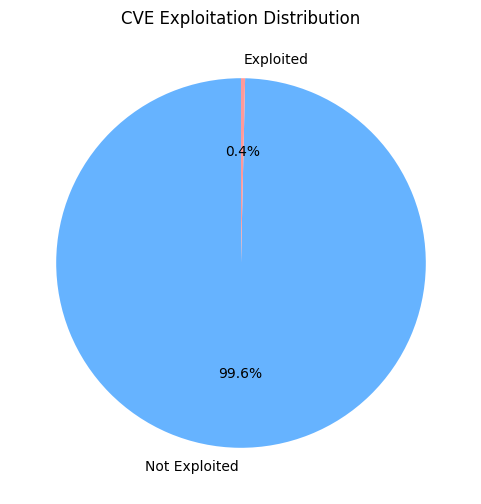

In [199]:
def main():

    kev_ids, kev_df = load_cisa_kev()

    # The maximum allowable range when using any date range parameters is 120 consecutive days. Also, max result per page is 2000
    cve_df = fetch_cves("2025-01-01","2025-02-28",2000,"a264b5f4-4416-4670-ab78-00258dcb0e72")

    flatten_cve_df = flatten_cve(cve_df)
    
    labelled_cve_df = label_cve_data(flatten_cve_df, kev_ids)

    #X, y, tfidf = generate_features(df)

    #X_train, X_test, y_train, y_test = temporal_split(df, X, y)

   # X_train, y_train = balance_data(X_train, y_train)

    #model = train_model(X_train, y_train)

    #evaluate_model(model, X_test, y_test)

    #show_top_features(model, tfidf)

    #save_files(model, tfidf)
if __name__ == "__main__":
    main()